In [1]:
%matplotlib inline
import ast
import json
import urllib
import urllib2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cStringIO import StringIO

We define a helper function <b>queryCartoDB</b> to wrap around the SQL API of CartoDB. We can simply pass in a public data source (in the form of 'https://{ACCOUNT}.cartodb.com/api/v2/sql', where ACCOUNT is the owner of the data) and a SQL statement for us to query the data in various formats including CSV, JSON, and GeoJSON. The result returned from this function is a file-like object, where we can pass to file readers such as Pandas' <b>read_csv()</b> or the JSON parser.

In our example, <b>source</b> is assigned a citibike data set available on the htv210 account.

We also assign <b>query1</b> and <b>query2</b> as the sample solution of homework 7.

In [2]:
def queryCartoDB(source, query, format='CSV'):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

source = 'https://htv210.cartodb.com/api/v2/sql'
query1 = open('hw7_1.sql', 'r').read()
query2 = open('hw7_2.sql', 'r').read()

We are just playing around with SQL statements in the next step. Note that, data can be retrieved in any format that we prefer.

In [3]:
query = '''
SELECT *
FROM citibike
LIMIT 10
'''

result = queryCartoDB(source, query, 'CSV')
df     = pd.read_csv(result)
df.head()

,cartodb_id,the_geom,the_geom_webmercator,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,21096,0101000020E6100000974341DF4C7E52C0D6668CA4175F...,0101000020110F0000B0339C78AF695FC16184389CE7F9...,201,2015-02-04 21:30:00+00,2/4/2015 21:33,518,E 39 St & 2 Ave,40.747804,-73.973442,528,2 Ave & E 31 St,40.742909,-73.977061,18336,Subscriber,1985,1
1,21676,0101000020E6100000C2448B85447F52C05723BBD23260...,0101000020110F000046DDFB20546B5FC13578821125FB...,352,2015-02-05 00:36:00+00,2/5/2015 0:42,486,Broadway & W 29 St,40.746201,-73.988557,490,8 Ave & W 33 St,40.751551,-73.993934,21270,Subscriber,1985,1
2,22599,0101000020E6100000BD772F52437F52C0A2165A08B85F...,0101000020110F0000C082E716526B5FC184A4D6689BFA...,679,2015-02-05 07:42:00+00,2/5/2015 7:53,505,6 Ave & W 33 St,40.749013,-73.988484,518,E 39 St & 2 Ave,40.747804,-73.973442,16495,Customer,NaN,0
3,23328,0101000020E61000000EB27625D37F52C0032DB87A295F...,0101000020110F0000164B2764466C5FC1FB99CB9AFBF9...,251,2015-02-05 08:30:00+00,2/5/2015 8:34,334,W 20 St & 7 Ave,40.742388,-73.997262,470,W 20 St & 8 Ave,40.743453,-74.000040,21258,Subscriber,1958,1
4,24685,0101000020E6100000523958C53C7F52C0183079EAAE5E...,0101000020110F00002E1B9FF6466B5FC149C2933772F9...,1255,2015-02-05 09:57:00+00,2/5/2015 10:18,498,Broadway & W 32 St,40.748549,-73.988084,168,W 18 St & 6 Ave,40.739713,-73.994564,18428,Customer,NaN,0


For the second query, where we would like visualize the output geometries, we use the Python's JSON module to parse the data and feed it to a GeoDataFrame. We can see the result in a plot

In [4]:
result = queryCartoDB(source, query2, 'GeoJSON')
data   = json.loads(result.read())
gdata  = gpd.GeoDataFrame.from_features(data['features'])

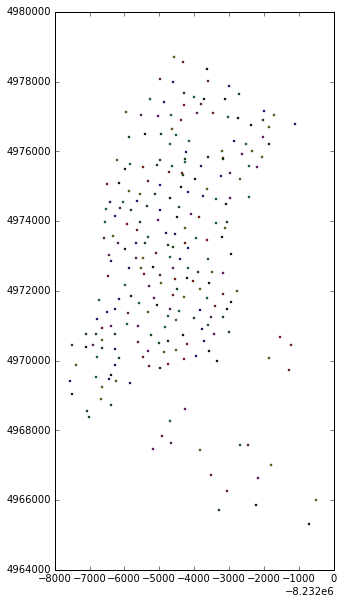

In [5]:
f, ax = plt.subplots(1, figsize=(5,10))
gdata.plot(column='trip_count', colormap='OrRd', alpha=1, axes=ax, scheme='QUANTILES', k=9)

To make the dots larger, we could create a buffer at each point (200 ft radius) and reassign the GeoDataFrame geometries.

In [6]:
dots   = gdata.set_geometry(gdata.geometry.buffer(100))

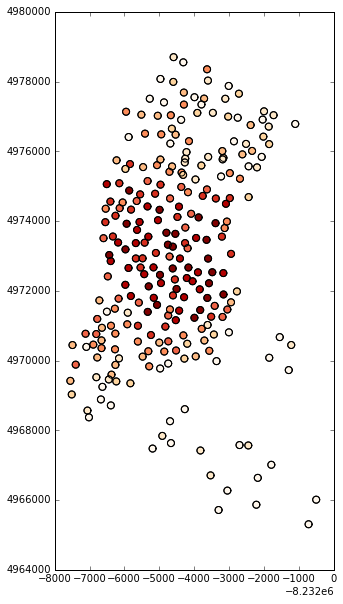

In [7]:
f, ax = plt.subplots(1, figsize=(5,10))
dots.plot(column='trip_count', colormap='OrRd', alpha=1, axes=ax, scheme='QUANTILES', k=9)